In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

from Bio import AlignIO
from Bio import SeqIO

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from collections import Counter

import sys

## Finding diverging positions in a single spike protein across samples

To recap: 
    1. I took a few GISAID samples, translated them to proteins
        accoridng to open reading frames. 
    2. I then globally align all these sequences with a single 
        canonical protein. 
    3. Parsing the alignment file gives me a one-to-many sequence
        and sequences that are >90% identical are selected and written 
        in a separate file, which is then passed on to this code. 

#### And now, I do the following: 
        
This code will turn each sequence into a numpy array and then calculate the 
conservation score via Shannon Entropy and plot the standardized normalized score
on a seaborn line plot. 

In [2]:
class DivergenceParser: 
    """Parse the globally aligned sequences to look for divergence"""
    
    def retrieve_dna(self, aligned_path): 
        """Extract the protein sequence from the FASTA file"""

        records = list(SeqIO.parse(aligned_path, "fasta"))
        seqs = [[x for x in y] for y in records]

        return seqs
    

    def seq2np(self, seq): 
        """"Turn the sequence into numpy S1 array for calculations later. 

        Args: 
            seq [2d list]: List of lists that contain sequences 

        Returns: 
            np array [2d np array]: Np array that turns the chars into bytes

        """

        return np.asarray(seq, dtype='S1')



    def normalize_data(self, ent_list): 
        """Takes the entropy array and normalizes the data. 

        Args: 
            ent_list [Nd array]: Entropy float array

        Returns: 
            Normalized list [nd array]: Values between -1 and 1

        """

        return -(ent_list - np.mean(ent_list, axis=0)) / np.std(ent_list, axis=0)  





    def _shannon(self, array): 
        """Calculate Shannon Entropy vertically via loop. 

        Args: 
            array [nd array]: 1d array of sequences from all the species

        Returns: 
            entropy [nd float array]: Per column value for each position vertically

        """
        
        aa_count = Counter(array)

        pA = 1
        for k, v in aa_count.items(): 
            pA *= (v / 21)

        return -np.sum(pA*np.log2(pA))

    

    def conservation_score(self, np_seq): 
        """Calculate the Shannon Entropy vertically
        for each position in the amino acid msa sequence.

        Args: 
            np_seq [Numpy nd array]: Np array of sequences

        Returns: 
            np apply array [nd float array]: Calculate conservation 
            scores vertically into a float nd array   
        """

        return np.apply_along_axis(self._shannon, 0, np_seq)  



    def moving_average(self, data, n=3) :
        """Calculated the rolling average of teh data

        Args: 
            data [numpy nd array]: Float array of the conservation score calculated
            n [int]: Rolling average wegith

        Returns: 
            avg_data [numpy nd array]: Float array of rolling average

        """
        
        avg_data = np.cumsum(data, dtype=float)
        avg_data[n:] = avg_data[n:] - avg_data[:-n]

        return avg_data[n - 1:] / n


    def label_plot(self, norm_list, norm_list_len, val, ax): 
        """Label the amino acids that are diverging from the aligned sequences"""
        
        a = np.concatenate({'x': norm_list_len, 'y': norm_list, 'val': val}, axis=1)
        for i, point in a.iteritems(): 
            ax.text(point['x']+.02, point['y'], str(point['val']))


['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']


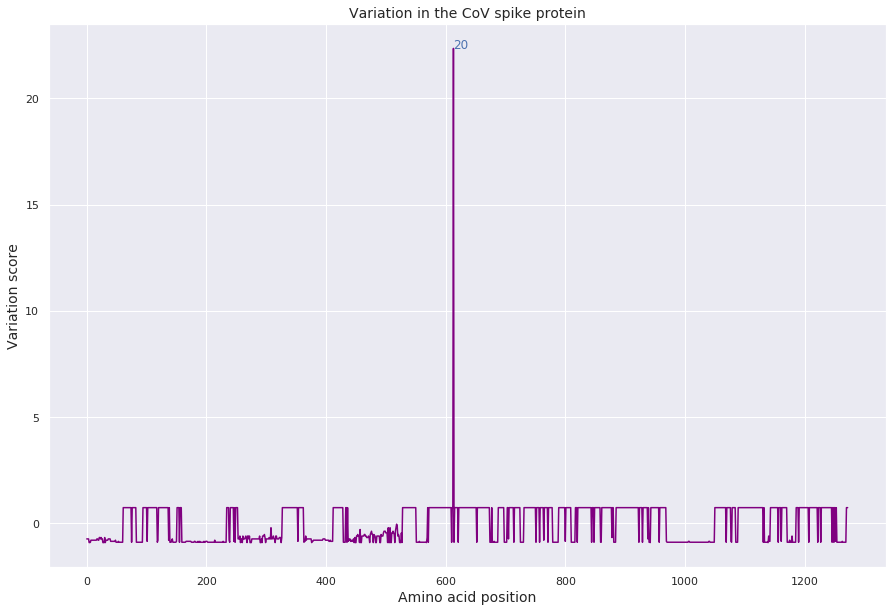

In [3]:
# Load the aligned FASTA file
aligned_path = "gisaid_results/mafft_aligned.fasta"

# Call an instance of the class
inst = DivergenceParser()

seqs = inst.retrieve_dna(aligned_path)

np_seq = inst.seq2np(seqs)

ent_list = inst.conservation_score(np_seq)
norm_list = inst.normalize_data(ent_list)

norm_list_len = np.arange(len(norm_list))

plt.figure(figsize=(15, 10))
ax=sns.lineplot (norm_list_len, norm_list, color="purple")

plt.xlabel("Amino acid position", fontsize=14)
plt.title("Variation in the CoV spike protein", fontsize=14)
plt.ylabel("Variation score", fontsize=14)

for x, y, name in zip(norm_list_len, norm_list, np_seq): 
    if y > 5: 
        aa_s = sorted(set(name.astype(str)))
        print(aa_s)
        ax.text(x,y, len(aa_s), color='b')
plt.show()



## Cross-check with another sample
The plot here shows that for this given GISAID dataset (about 16k sequences in total), the divergence at the 613th position shows the highest amount of divergence. In fact, we can see that the position can have all the possible amino acids in that position. 
I've done this for another GISAID sample (a comparatively smaller one) that shows that this position does indeed show maximum divergence. 

In [1]:
aligned_path2 = Path("gisaid_results/trimmed_seqs.fasta")

inst2 = DivergenceParser()


seqs2 = inst2.retrieve_dna(aligned_path)

np_seq2 = inst2.seq2np(seqs)

ent_list2 = inst2.conservation_score(np_seq)
norm_list2 = inst2.normalize_data(ent_list)

norm_list_len2 = np.arange(len(norm_list2))

plt.figure(figsize=(15, 10))
ax2=sns.lineplot (norm_list_len2, norm_list2)

plt.xlabel("Amino acid position", fontsize=14)
plt.title("Variation in the CoV spike protein", fontsize=14)
plt.ylabel("Variation score", fontsize=14)

for x2, y2, name in zip(norm_list_len2, norm_list2, np_seq2): 
    if y2 > 5: 
        aa_s2 = sorted(set(name.astype(str)))
        print(aa_s2)
        ax2.text(x2,y2, len(aa_s2), color='b')
                
plt.show()

NameError: name 'Path' is not defined

## Validation
Seems like this 614th position (I start with 0, so mine is 613) is not new. This has already been reported in the following Biorxiv paper: 
    https://www.biorxiv.org/content/10.1101/2020.04.29.069054v1.full.pdf
    
    
 From the article's abstract: 
  " Here we describe a three-stage data pipeline (analysis of daily GISAID data, structural modeling of sites of interest, and experimentalevaluation) and the identification of several sites of positive selection, including one (D614G) thatmay have originated either in China or Europe, butbegin tospread rapidly first in Europe, and thenin otherparts of the world,and which is now the dominant pandemic form in manycountries."

## Contribution
Here however, I present the result that this 614th position doesn't only contain aspartic acid / glutamine substitution, but this position can be substituted by ALL amino acids. 

What I can surmise is that the position isn't affected by mutation since there's no base bias towards one or any other physiochemically similar proteins. 